In [1]:
using QuadraticTeamDecisionSolver, Distributions, Statistics, LinearAlgebra, Plots, LaTeXStrings

In [2]:
#replace with desired directory
saveTo = "/home/fe/michelena/Schreibtisch/thesis/progress"

"/home/fe/michelena/Schreibtisch/thesis/progress"

In [3]:
N = 2;
σᵣ = 1.5;
p = QuadTeamProblem(N, N * N * ones(Int64, N), ones(Int64, N), ComplexF64);
t = teamMMSEproblem(
	σᵣ,
	zeros(Float64, N),
	ones(Float64, N),
	zeros(Float64, N),
	0.5 * ones(Float64, N),
	0.0 * ones(Float64, N),
);


In [4]:
function solver!(
	p,
	w,
	Y,
	R,
	r;
	iterations = 10,
	h = 0.05,
	λ = 0.1,
)
	k(x, y; h = h) = exp((-norm(x - y)^2) / h)
	regression(Y, X) = kernelInterpolation(k, Y, X, λ = λ)
	regressor(w, X, x) = kernelFunction(k, w, X, x)
	return empiricalJacobiSolver!(
		p,
		w,
		Y,
		R,
		r,
		regression,
		regressor,
		iterations = iterations,
	)
end


solver! (generic function with 1 method)

In [5]:
m = 2000;
iterations = 10;
Y, R, r = generateTeamMMSEsamples(p, t, m);

In [6]:
Ytt = reformatYm(p.N, m, Y)[1]

2-element Vector{Vector{ComplexF64}}:
 [0.06423085384754645 - 0.61663295996305im, 0.04032890625749488 + 0.7006346010004977im, 0.18204578910680932 + 0.3015931728645408im, -0.6163003812791854 + 0.13211323928158508im]
 [0.06423085384754645 - 0.61663295996305im, 0.04032890625749488 + 0.7006346010004977im, 0.18204578910680932 + 0.3015931728645408im, -0.6163003812791854 + 0.13211323928158508im]

In [7]:
Ytt[1]

4-element Vector{ComplexF64}:
 0.06423085384754645 - 0.61663295996305im
 0.04032890625749488 + 0.7006346010004977im
 0.18204578910680932 + 0.3015931728645408im
 -0.6163003812791854 + 0.13211323928158508im

In [8]:
w_jacobi = [[rand(ComplexF64, m)] for _ in 1:p.N];
solver!(p, w_jacobi, Y, R, r);

In [9]:
conv_jacobi = [norm.(diff(w_jacobi[i])) for i in 1:p.N];

In [10]:
testR = reformatR(p.N, m, R);
testr = reformatr(p.N, m, r);
testW_jacobi = reformatU(p.N, m, iterations, w_jacobi);

In [11]:
perf_jacobi = [urisk(testW_jacobi[k], testR, testr) for k in 1:iterations];

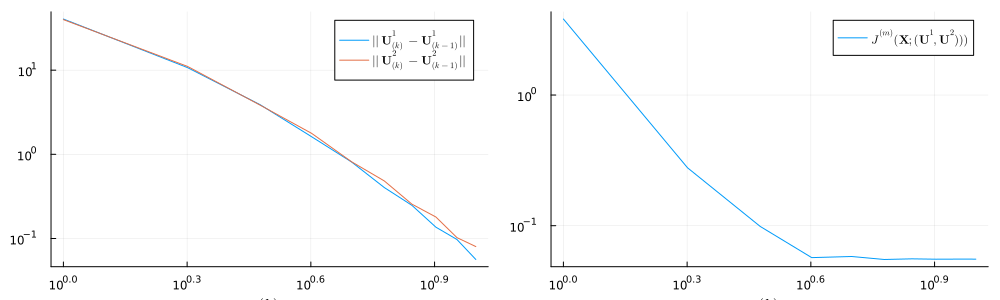

In [12]:
conv = plot(
	conv_jacobi,
	xscale = :log10,
	yscale = :log10,
	xlabel = L"(k)",
	label = [L"||\mathbf{U}_{(k)}^1 - \mathbf{U}_{(k-1)}^1||" L"||\mathbf{U}_{(k)}^2 - \mathbf{U}_{(k-1)}^2||"],
);
perf = plot(
	perf_jacobi,
	yscale = :log10,
	xscale = :log10,
	xlabel = L"(k)",
	label = L"J^{(m)}(\mathbf{X}; (\mathbf{U}^1, \mathbf{U}^2)))",
);
plot(conv, perf, layout = (1, 2), size = (1000, 300))
savefig(saveTo * "/convergence.png");
display(Plots.current())


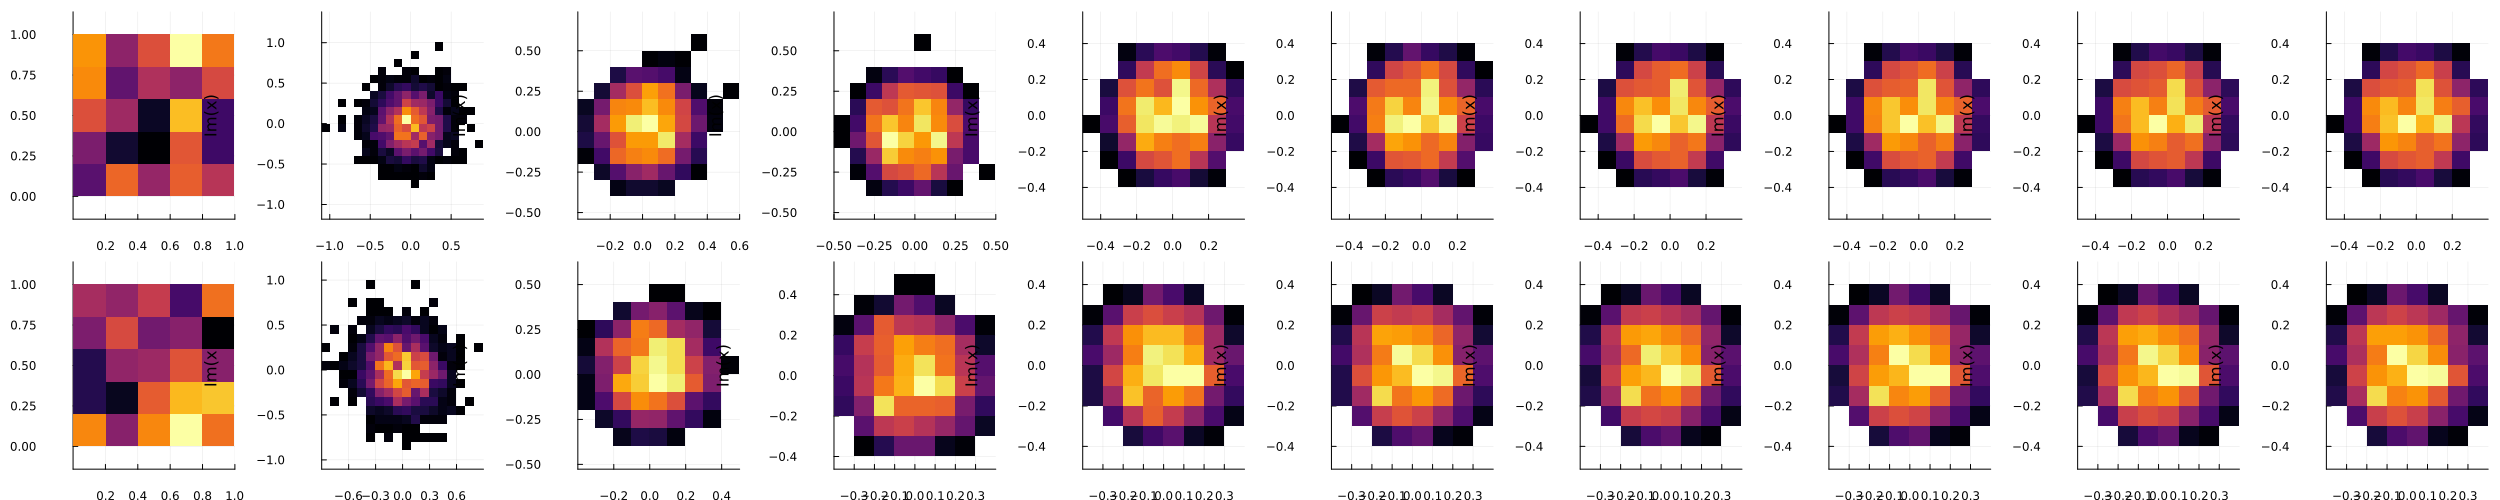

In [13]:
# Step 2: Create a 1x5 grid of subplots
plot_layout = plot(layout=(2, iterations), legend=false)

# Step 3: Generate histograms and add them to the grid
for k in 1:iterations
    h1 = histogram2d(
        w_jacobi[1][k],
        normalize=:pdf,
        show_empty_bins=false,
        normed=true,
        aspect_ratio=1,
    )
    histogram2d!(
        plot_layout[k],
        w_jacobi[1][k],
        normalize=:pdf,
        show_empty_bins=false,
        normed=true,
        aspect_ratio=1,
    )

    h2 = histogram2d(
        w_jacobi[2][k],
        normalize=:pdf,
        show_empty_bins=false,
        normed=true,
        aspect_ratio=1,
    )
    histogram2d!(
        plot_layout[2, k],
        w_jacobi[2][k],
        normalize=:pdf,
        show_empty_bins=false,
        normed=true,
        aspect_ratio=1,
    )
end

# Step 4: Show the plot
plot(plot_layout, size=(2500, 500))
savefig(saveTo * "/evolution.png");
display(Plots.current())

In [14]:
sinrRange = 10 .^ range(start = -10, stop = 10, length = 5);
sinrResult = [
	sinrExperiment(
		p,
		solver!,
		sinr;
		samples = 1000,
		iterations = 10,
		bandwidth = 0.5,
		regularizer = 0.2,
		eps = 0.0,
	) for sinr in sinrRange
];


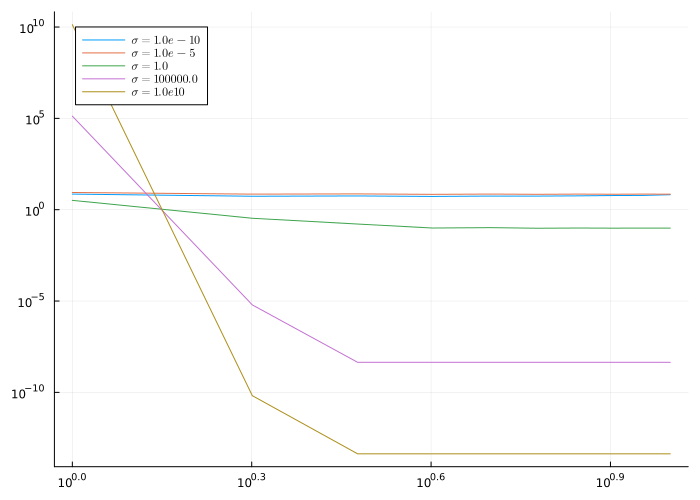

In [15]:
sinrplt = plot(size = (700, 500))
for (sinr, curve) in zip(sinrRange, sinrResult)
	plot!(sinrplt, curve, yscale = :log10, xscale = :log10, label=latexstring("\\sigma = $(sinr)"), legend=:topleft)
end
savefig(saveTo * "/sinrplt.png");
display(Plots.current())


In [37]:
hRange = 10 .^ range(start = -15, stop = 10, length = 10);
hResult = [
	bandwidthExperiment(
		p,
		solver!,
		h;
		samples = 1000,
		iterations = 10,
		sinr = 1.5,
		regularizer = 0.2,
		eps = 0.0,
	) for h in hRange
];

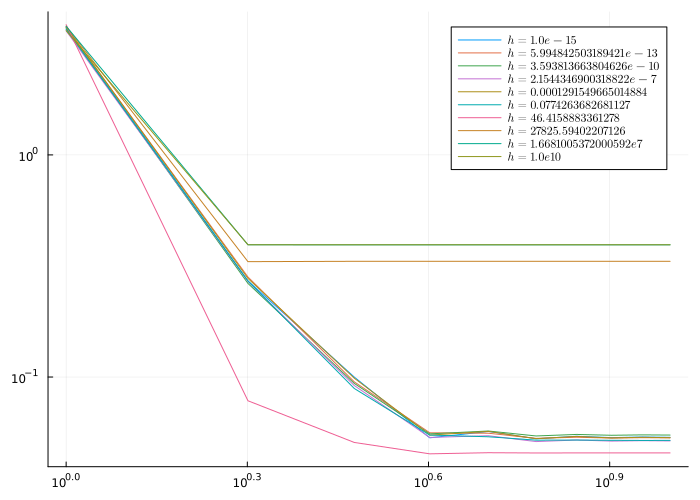

In [40]:
hplt = plot(size = (700, 500))
for (h, curve) in zip(hRange, hResult)
	plot!(hplt, curve, yscale = :log10, xscale = :log10, label=latexstring("h = $(h)"))
	
end
savefig(saveTo * "/hplt.png");
display(Plots.current())

In [18]:
function tsamplesExperiment(
	p::QuadTeamProblem,
	samples::Int;
	bandwidth = 0.05,
	iterations = 10,
	sinr = 1.5,
	regularizer = 0.5,
	eps = 0.0,
	testSamples = 10000,
)
	t = teamMMSEproblem(
		sinr,
		zeros(Float64, p.N),
		ones(Float64, p.N),
		zeros(Float64, p.N),
		0.5 * ones(Float64, p.N),
		eps * ones(Float64, p.N),
	)
	#train
	Y, R, r = generateTeamMMSEsamples(p, t, samples)
	U = [[rand(ComplexF64, samples)] for _ ∈ 1:p.N]

	k(x, y) = exp((-norm(x - y)^2) / bandwidth)
	regression(Y, X) = kernelInterpolation(k, Y, X, λ = regularizer)
	regressor(w, X, x) = kernelFunction(k, w, X, x)

	empiricalJacobiSolver!(
		p,
		U,
		Y,
		R,
		r,
		regression,
		regressor,
		iterations = iterations,
	)

	W = [
		[kernelInterpolation(k, U[i][l], Y[i], λ = regularizer) for i in 1:p.N] for
		l in 1:iterations
	]

	#test
	Yt, Rt, rt = generateTeamMMSEsamples(p, t, testSamples)
	Ytt = reformatYm(p.N, testSamples, Yt)
	Rtt = reformatR(p.N, testSamples, Rt)
	rtt = reformatr(p.N, testSamples, rt)

	S = [Sample(Y, R, r, 1.0+0.0im) for (Y, R, r) in zip(Ytt, Rtt, rtt)]

	return risk(S, [x -> kernelFunction(k, W[end][i], Y[i], x) for i in 1:p.N])
end

tsamplesExperiment (generic function with 1 method)

In [46]:
sampleRange = 10 .^ range(start = 0, stop = 3, length = 10) .|> x -> round(Int64, x);
samplesResult = [
	[
		tsamplesExperiment(
			p,
			samples;
			bandwidth = 1.0,
			iterations = l,
			sinr = 1.5,
			regularizer = 0.2,
			eps = 0.0,
		) for samples in sampleRange
	] for l in 1:2:11
];


In [47]:
samplesResult

10-element Vector{Vector{Float64}}:
 [0.3867023453554195, 0.44651373330506455, 0.4963799521953757, 0.6266469698210081, 1.1961112455665908, 1.5432914163483433, 1.7931981259603385, 2.337152407905358, 2.436343139811198, 2.7565933763509336]
 [0.39084795519119514, 0.37688044176805907, 0.3368080577865242, 0.33057944499830993, 0.27814818047319845, 0.2003516459864994, 0.15607242098009969, 0.1423824933288174, 0.15320414651048342, 0.1663313336674419]
 [0.38474797701629954, 0.38356534221414795, 0.3495053719905224, 0.331437282357385, 0.2881020015485468, 0.2036793530439397, 0.1535408274339306, 0.11738277085036812, 0.09700611369643866, 0.08904830937111713]
 [0.39047628193593376, 0.3862108967292137, 0.3628636106930246, 0.31915246508531825, 0.2615341459140594, 0.2120018128455602, 0.14150701003580501, 0.10436114255695174, 0.07934171201156617, 0.06707579594742827]
 [0.38662275115128786, 0.37671109136246606, 0.3345615022937284, 0.32998438496212495, 0.2569685401869669, 0.20825421950601514, 0.1394964472638

In [44]:
errorEstimate(m) = m^(-2/(2 + p.N^2))

errorEstimate (generic function with 1 method)

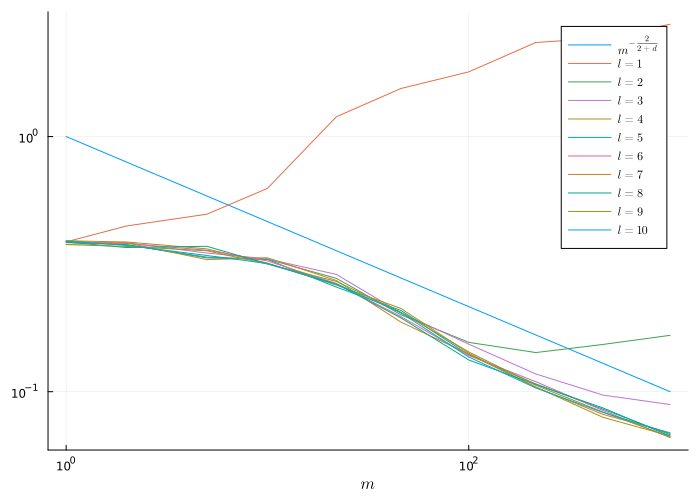

In [60]:
samplesplt =
	plot(sampleRange, errorEstimate.(sampleRange), yscale=:log10, xscale=:log10, label=L"m^{-\frac{2}{2+d}}", xlabel = L"m", legend=:topright, size = (700, 500))
for (errorCurve, l) in zip(samplesResult, 1:10)
	plot!(
		samplesplt,
		sampleRange,
		errorCurve,
		yscale = :log10,
		xscale=:log10,
		label = latexstring("l = $(l)"),
	)
end
savefig(saveTo * "/samplesplt.png");
display(Plots.current())
